#

# Introduction

This notebook uses the utils in this codebase to perform end-to-end machine learning model development on the [Criteo Display Ads Challenge Dataset](https://paperswithcode.com/dataset/criteo). 

The aim of this challenge is to predict click-through-rates (CTR) for ads, based on anonymised Criteo logs data. Predicting CTR or other forms of engagements is also done in search ranking. We use pointwise ranking approaches in this notebook.

The main difference between (search) ranking and CTR prediction is that these ads do not belong to a specific user's query and corresponding impressions, so we cannot calculate ranking metrics. However, we can calculate pointwise metrics. This dataset is also limited in that we do not have user or product identifiers. This means we cannot create a baseline based on popularity.

This notebook will perform the following steps:

1. Setup - Set up the notebook by importing built-in, external and locally developed packages. Also we load in the data.
2. Exploratory Data Analysis (*EDA*) - Gain insight into the dataset to understand the domain, quality of the data and what inputs might help build a good model. Most of the EDA is done ad-hoc, not using the utils.
3. Data Preprocessing - Clean the data and handle non-numerical inputs. This will be heavily driven by the `Schema` object defined [here](../search_ranking_utils/utils/schema.py).
4. Model Development - Create and train a variety of binary classification models.
5. Model Evaluation - Understand how well the models can predict CTR, and output useful visualisations.

# Setup

In [1]:
# Built-in libraries
import logging

# External Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Locally developed package
from search_ranking_utils.utils.schema import Schema
from search_ranking_utils.preprocessing.preprocessor import Preprocessor
from search_ranking_utils.preprocessing.data_preprocessing import split_dataset
from search_ranking_utils.modelling.model_factory import ModelFactory
from search_ranking_utils.evaluation.metrics import get_pointwise_metrics

# Data is not committed in this repo
train = pd.read_csv("../data/criteo/train.csv")
test = pd.read_csv("../data/criteo/test.csv")

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
)

# EDA

The aim of Exploratory Data Analysis is to understand the quality and relationships within our data. This understanding will help determine how to best preprocess the data for model training. It will also allow us to know what inputs will best help predict when there is a click, and when there is not a click. **We do not perform EDA on testing data, as we assume its not known at the time of prediction**.

We perform the following tasks:
1. Summary Statistics - Gain a basic understanding of our data, by looking at:
 - Number of rows and columns
 - Duplicate rows
 - Nulls for each column
 - Min/Max of features
 - Number of categories for non-numerical features
 - Distribution of the target
 - Correlation between numerical features
2. Target-based distributions - See how features are distributed for each target, to see if these features can help separate the classes.
  - Categorical - Look at the top 5 / bottom 5 proportion of label = 1 categories for each feature
  - Numerical - Plot the distribution for each label. Outliers may need to be rounded down to visualise these properly

In [2]:
# Get a basic understanding of what features, and how many nulls we have
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Label     20000 non-null  int64  
 1   I1        11035 non-null  float64
 2   I2        20000 non-null  int64  
 3   I3        16025 non-null  float64
 4   I4        16121 non-null  float64
 5   I5        19012 non-null  float64
 6   I6        14945 non-null  float64
 7   I7        18994 non-null  float64
 8   I8        19982 non-null  float64
 9   I9        18994 non-null  float64
 10  I10       11035 non-null  float64
 11  I11       18994 non-null  float64
 12  I12       4522 non-null   float64
 13  I13       16121 non-null  float64
 14  C1        20000 non-null  object 
 15  C2        20000 non-null  object 
 16  C3        19229 non-null  object 
 17  C4        19229 non-null  object 
 18  C5        20000 non-null  object 
 19  C6        17287 non-null  object 
 20  C7        20000 non-null  ob

In [3]:
# Check proportion of duplicate rows and drop them
prop_duplicates = (len(train) - len(train.drop_duplicates())) / len(train)
print(f"Proportion duplicates: {prop_duplicates}")
train = train.drop_duplicates()

Proportion duplicates: 5e-05


In [4]:
# Check min/max of numerical features
train.describe()

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
count,19999.000000,11035.000000,19999.000000,16024.000000,16121.000000,1.901100e+04,14945.000000,18993.000000,19981.000000,18993.000000,11035.000000,18993.000000,4522.000000,16121.000000
mean,0.224311,3.428727,112.132357,47.868947,8.194529,1.741524e+04,146.156039,14.757332,13.275312,125.799347,0.590757,2.351445,0.937417,11.264562
std,0.417138,9.104148,422.215392,845.376883,11.118519,6.337262e+04,381.079132,56.225661,38.299138,280.680153,0.664615,4.576833,4.726852,39.809611
min,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,2.000000,2.410000e+02,9.000000,0.000000,2.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.000000,3.000000,7.000000,4.000000,2.391000e+03,40.000000,3.000000,8.000000,41.000000,1.000000,1.000000,0.000000,5.000000
75%,0.000000,3.000000,39.000000,22.000000,11.000000,1.039750e+04,132.000000,10.000000,20.000000,122.000000,1.000000,2.000000,1.000000,13.000000
max,1.000000,214.000000,18522.000000,65535.000000,380.000000,1.618112e+06,13560.000000,2061.000000,4352.000000,7338.000000,6.000000,84.000000,178.000000,4016.000000


In [5]:
# Check min/max of categorical features
train.describe(include=np.object_)

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,query_id
count,19999,19999,19229,19229,19999,17286,19999,19999,19999,19999,...,19999,11337,11337,19229,3606,19999,19229,11337,11337,19999
unique,236,430,10179,6944,72,10,4488,128,3,4597,...,1494,735,3,9170,10,14,4077,41,3151,1
top,05db9164,38a947a1,d032c263,d16679b9,25c83c98,7e0ccccf,3f4ec687,0b153874,a73ee510,3b08e48b,...,5aed7436,21ddcdc9,5840adea,0014c32a,ad3062eb,32c7478e,1793a828,e8b83407,49d68486,query_id
freq,10030,2448,861,1229,13363,9272,211,11802,17694,5394,...,1024,6837,4243,861,1868,8976,1503,3675,940,19999


In [6]:
# Distribution of the target
train["Label"].value_counts(normalize=True)

Label
0    0.775689
1    0.224311
Name: proportion, dtype: float64

<Axes: >

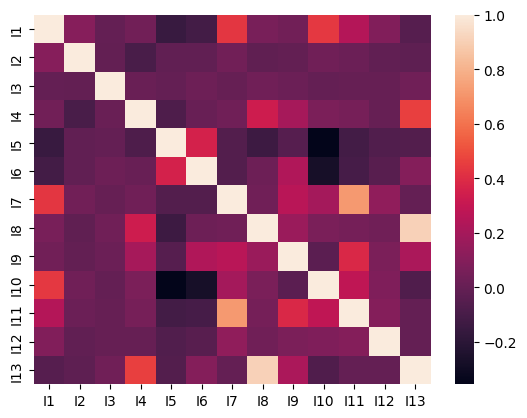

In [7]:
# Correlation between numerical features
numerical_features = train.select_dtypes([np.float64, np.int64, np.int32]).drop("Label", axis=1).columns
categorical_features = train.select_dtypes([np.object_]).columns
sns.heatmap(train[numerical_features].corr())

From looking at the summary stats, we can see:
1. There is a very small number of duplicates rows, and we drop them above.
2. Numerical features are on various scales, and likely contain outliers.
3. Some categorical features have a very high cardinality, and others have low cardinality.
4. ~3/4 of the data has the negative label.
5. Certain numerical features are strongly positively correlated, such as I5 and I6, or I1 and I7. Strong negative correlations are not present.

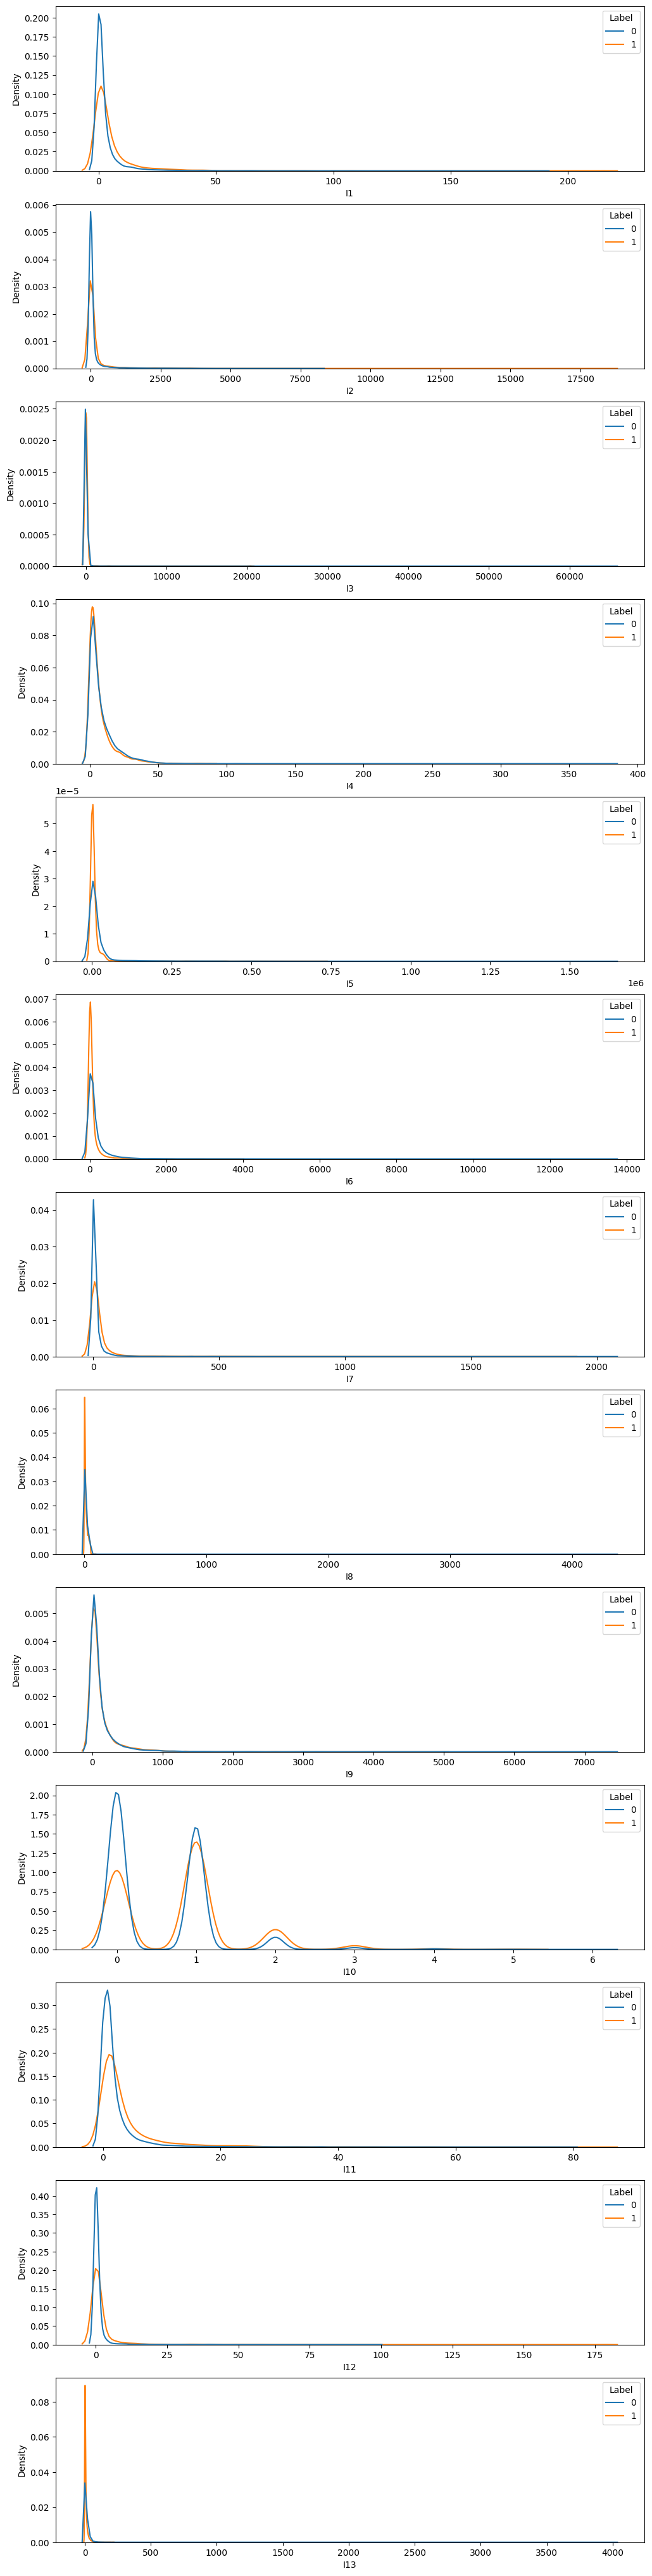

In [8]:
# Plot the distribution of numerical features based on the label
fig,axes = plt.subplots(len(numerical_features), figsize=(12, len(numerical_features) * 4))
for i,feature in enumerate(numerical_features):
    sns.kdeplot(data=train, x=feature, common_norm=False, hue="Label", ax=axes[i])

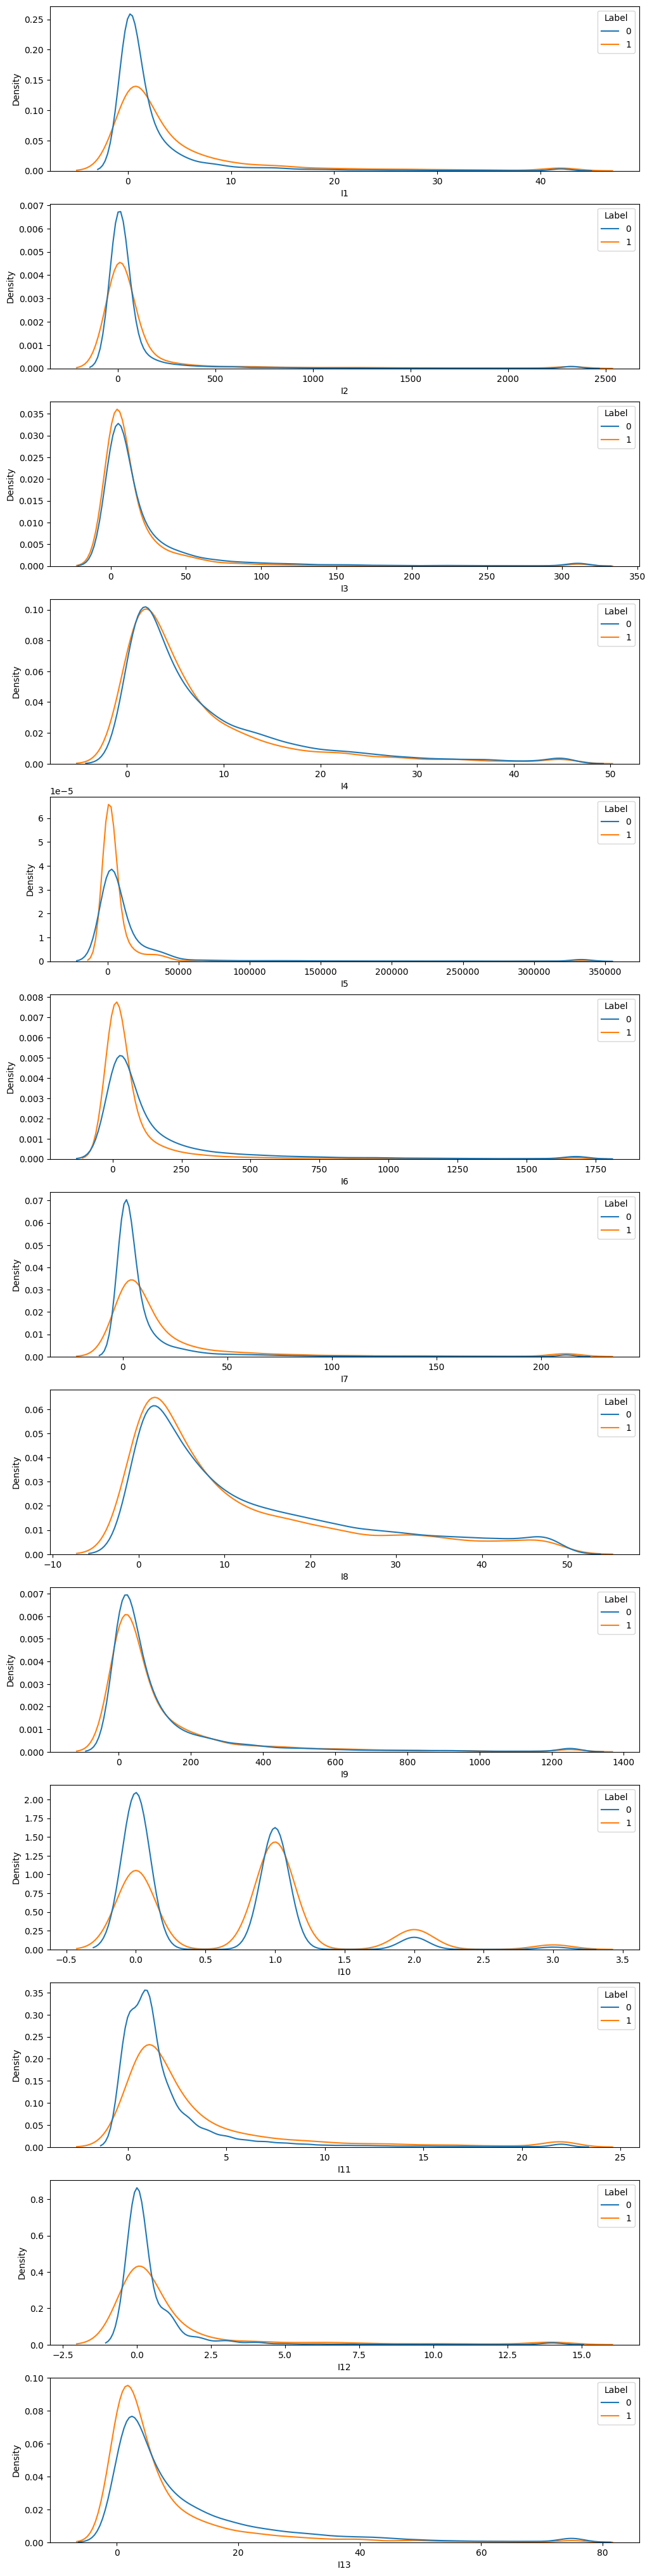

In [9]:
# There are some very extreme values in the long tails, making it harder to visualise
# Let's clip all values above the 99th percentile to the 99th percentile
for feature in numerical_features:
    percentile_99 = train[feature].quantile(0.99)
    train[feature] = train[feature].apply(lambda x: min(x, percentile_99))

# Now we have handled outliers, try plotting
# Here we plot each numerical feature 
fig,axes = plt.subplots(len(numerical_features), figsize=(12, len(numerical_features) * 4))
for i,feature in enumerate(numerical_features):
    sns.kdeplot(data=train, x=feature, common_norm=False, hue="Label", ax=axes[i])

Looks like I1, I5, I6, I7, I10 and I11 have particularly different distributions between label values. Since I5 and I6 are strongly correlated, we choose I6 as it has a smoother distribution suggesting it is less noisy.

In [10]:
# For categorical features, we will look at the highest 5 label probability = 1 and lowest 5 for each categorical feature
for feature in categorical_features:
    grouped = train.groupby(feature)["Label"].aggregate(["mean", "size"]).sort_values(by="mean", ascending=False)
    # Don't take those with absolute probs
    grouped = grouped[(grouped["mean"] > 0.0) & (grouped["mean"] < 1.0)]
    print(f"Feature {feature} Top 5: {grouped.head(5)}, Bottom 5: {grouped.tail(5)}")

Feature C1 Top 5:               mean  size
C1                      
0a16e1d4  0.666667     3
3560b08b  0.500000     6
c512b859  0.500000     2
6bcf7a5b  0.500000     2
9e9d28f5  0.500000     2, Bottom 5:               mean  size
C1                      
dac91c28  0.111111     9
ff004ae3  0.111111     9
87773c45  0.100000    10
9684fd4d  0.090909    11
64e77ae7  0.076923    13
Feature C2 Top 5:               mean  size
C2                      
d9060812  0.700000    10
c1c79489  0.666667     3
482fe41f  0.666667     3
5a88f1d5  0.666667     3
2a8248f5  0.666667     3, Bottom 5:               mean  size
C2                      
8ab240be  0.053333    75
d57c0709  0.047619    21
097e9399  0.043478    46
bc84a2bc  0.043478    23
8084ee93  0.036101   277
Feature C3 Top 5:               mean  size
C3                      
bce3f26f  0.857143     7
95c48c52  0.800000     5
c2b2b3f5  0.800000    10
6406abee  0.800000     5
d0c01507  0.800000     5, Bottom 5:               mean  size
C3           

For simplicity, let's use C2, C4, C5 and C7 because they have quite a few categories with high label probs and low label probs. In addition, we can see that the categorical features have quite a high number of unique categories. To reduce the number of features generated via One hot encoding, we only include the top 500 categories. All other categories are put into the bucket `~OTHER~`.

This brings our feature set to:
- Numerical: I1, I6, I7, I10, I11
- Categorical: C2, C4, C5, C7

# Data Preprocessing

Now we understand what our data looks like, we can clean our data and prepare it for model training. This preprocessing is driven by a custom `Schema` class, which stores the relevant statistics for preprocessing. In particular we do the following steps in sequence:

1. Imputation - Replace missing values either using aggregate statistics (such as mean or mode) or using specific values
2. Normalisation - Normalise features by subtracting their mean and dividing by their standard deviation. This gives features a common scale interpretation and stabilises training of linear and Neural Network models
3. Map Out of Vocabulary Categories - Create a mapping between a categorical feature and all the values it can take. Since we limit the max categories to 500, only the most common 500 categories are included. Others are transformed to the value `~OTHER~`
4. One Hot Encoder - One Hot Encode the categorical features based on the feature vocab (which may be restricted due to max categories)

In [11]:
# Everything is driven by the schema
schema_dict = {
    "features": {
        "categorical": {
            "C2": {
                "impute": {
                    "impute_type": "val",
                    "val": "unknown"
                },
                "max_categories": 500
            },
            "C4": {
                "impute": {
                    "impute_type": "mode"
                },
                "max_categories": 500
            },
            "C5": {
                "impute": {
                    "impute_type": "mode"
                },
                "max_categories": 500
            },
            "C7": {
                "impute": {
                    "impute_type": "mode"
                },
                "max_categories": 500
            }
        },
        "numerical": {
            "I1": {
                "impute": {
                    "impute_type": "mean"
                }
            },
            "I6": {
                "impute": {
                    "impute_type": "median"
                }
            },
            "I7": {
                "impute": {
                    "impute_type": "median"
                }
            },
            "I10": {
                "impute": {
                    "impute_type": "median"
                }
            },
            "I11": {
                "impute": {
                    "impute_type": "val",
                    "val": 0,
                }
            },
        }
    },
    "target": "Label",
    "query_col": "query_id"
}

In [12]:
# Create the schema
schema = Schema.create_instance_from_dict(schema_dict)

2024-07-29 16:16:23,361 | INFO | search_ranking_utils.utils.schema | Creating schema using: {'features': {'categorical': {'C2': {'impute': {'impute_type': 'val', 'val': 'unknown'}, 'max_categories': 500}, 'C4': {'impute': {'impute_type': 'mode'}, 'max_categories': 500}, 'C5': {'impute': {'impute_type': 'mode'}, 'max_categories': 500}, 'C7': {'impute': {'impute_type': 'mode'}, 'max_categories': 500}}, 'numerical': {'I1': {'impute': {'impute_type': 'mean'}}, 'I6': {'impute': {'impute_type': 'median'}}, 'I7': {'impute': {'impute_type': 'median'}}, 'I10': {'impute': {'impute_type': 'median'}}, 'I11': {'impute': {'impute_type': 'val', 'val': 0}}}}, 'target': 'Label', 'query_col': 'query_id'}


In [13]:
# Create a preprocessor from training
# This exact same preprocessor will be used to preprocess validation data
# A preprocessor won't be refit to that validation data
schema.set_stats(train)
preprocessor = Preprocessor(
    train,
    schema
)

In [14]:
# We want to do the following
# Drop all un-used features
# Impute any missing values
# Normalise numerical data
# Limit the number of categories if necessary
# One hot encode categorical features
preprocessed_train = preprocessor(train)

2024-07-29 16:16:23,397 | INFO | search_ranking_utils.preprocessing.data_preprocessing | Imputations: {'C2': 'unknown', 'C4': 'd16679b9', 'C5': '25c83c98', 'C7': '3f4ec687', 'I1': 3.167467149977345, 'I6': 40.0, 'I7': 3.0, 'I10': 1.0, 'I11': 0}
2024-07-29 16:16:23,405 | INFO | search_ranking_utils.preprocessing.data_preprocessing | Norm stats: {'I1': {'mean': 3.167467149977345, 'std': 6.6902148055332535}, 'I6': {'mean': 135.07674807627967, 'std': 261.20913555102317}, 'I7': {'mean': 12.440225346180153, 'std': 29.64459551364137}, 'I10': {'mean': 0.5877661984594472, 'std': 0.6504100320468662}, 'I11': {'mean': 2.2248723213815618, 'std': 3.5795109450154547}}


In [15]:
# Inspect the pre-processed data to make sure it is as expected
num_nulls = preprocessed_train.isna().sum().sum()
print(f"Num Nulls in preprocessed data: {num_nulls}")

num_unique_c2_categories = len([col for col in preprocessed_train.columns if col.startswith("C7")])
print(f"Num unique C7 categories: {num_unique_c2_categories}")

Num Nulls in preprocessed data: 0
Num unique C7 categories: 501


In [16]:
# Check that numerical data has been normalised
print(f'Original data: {train["I1"].iloc[0]}')
print(f'Normalised data: {preprocessed_train["I1"].iloc[0]}')

Original data: 1.0
Normalised data: -0.3239757187145479


# Model Training

Now that the data has been cleaned and preprocessed, we can train some machine learning models. In order to understand how good a model is, we need to have an appropriate baseline in place. A `ModelFactory` class is implemented in this package which can fetch any model class from any external or locally developed package as long as the necessary constructor arguments are passed. We train the following models:

1. Logistic Regression (baseline)
2. Random Forest
3. XGBoost
4. Wide and Deep Neural Network model

We use Logistic Regression from Sklearn as a baseline. This model assumes that the underlying relationship between our input features and the target label is linear. It also does not interact features within the model. The model takes a linear weighted (weights are learnt in training) sum and passes it through the sigmoid activation function, to ensure that the output is always between 0 and 1. 

The second model we try is Random Forest. This model trains multiple Decision Trees (weak learners) and averages their predictions (bagging) to get a final probability prediction. Decision Trees are learnt by finding the feature and corresponding value that best separates the classes. This process continues until the classes can no longer be separated, or a maximum specified tree depth is reached. Decision Trees create feature interactions as the data is split based on a collection of feature value if-else statements, eg. I1 > 2.0, then C1 = 'example_category" etc. Decision Trees tend to overfit the data they are trained on, so Random Forest aims to get around this by training many trees on different subsamples of data and averaging the results. 

The third model we try is XGBoost. The model is again built from Decision Trees. However, instead of averaging their results, it builds trees sequentially (boosting), where the current tree is fit on the residuals between the outcome from a model composed of all the previous trees, and the true labels. In this way, the model aims to consistently get better by correcting its past mistakes. Given the nature of the model to consistently try and correct its own mistakes, it can overfit if hyperparamters are not chosen appropriately. 

The final model we try is the Wide and Deep architecture ([paper](https://arxiv.org/pdf/1606.07792)). This has been a key component of modern day recommender systems. Intuitively, it has two components. Firstly, categorical, one-hot encoded features are fed into a Logistic Regression layer (wide tower). The rationale being that strong trends can be "memorised" from the data. Secondly, numerical features or embedded categorical features are fed into a feed-forward neural network with non-linear activations. The rationale being that all these features interact with each other implicitly via the feed-forward neural network, and thus can generalise relationships in the data. Finally, the output of the two towers is summed and passed through a sigmoid activation (the paper concatenates these instead, and projects to a single output then sigmoids). This model performs well on large-scale data, but on smaller datasets might not yield beneficial results compared to Random Forest of XGBoost. The default optimiser for model fitting is Adam.

In [17]:
# Logistic Regression
lr = ModelFactory.get_instance_from_config(
    "sklearn.linear_model:LogisticRegression",
    {
        "C": 0.01
    }
)
preprocessed_train, X, y = split_dataset(preprocessed_train, schema)

lr.fit(X, y)

2024-07-29 16:16:23,583 | INFO | search_ranking_utils.modelling.model_factory | Creating model: sklearn.linear_model - LogisticRegression
2024-07-29 16:16:23,670 | INFO | search_ranking_utils.modelling.model_factory | Creating LogisticRegression using {'C': 0.01}


LogisticRegression(C=0.01)

In [18]:
# Random Forest
random_forest = ModelFactory.get_instance_from_config(
    "sklearn.ensemble:RandomForestClassifier",
    {
        "n_estimators": 50,
        "max_depth": 50
    }
)

random_forest.fit(X, y)

2024-07-29 16:16:24,298 | INFO | search_ranking_utils.modelling.model_factory | Creating model: sklearn.ensemble - RandomForestClassifier
2024-07-29 16:16:24,630 | INFO | search_ranking_utils.modelling.model_factory | Creating RandomForestClassifier using {'n_estimators': 50, 'max_depth': 50}


RandomForestClassifier(max_depth=50, n_estimators=50)

In [19]:
# XGBoost 
xgb = ModelFactory.get_instance_from_config(
    "xgboost:XGBClassifier",
    {
        "n_estimators": 50,
        "max_depth": 6
    }
)

xgb.fit(X, y)

2024-07-29 16:16:28,158 | INFO | search_ranking_utils.modelling.model_factory | Creating model: xgboost - XGBClassifier
2024-07-29 16:16:28,295 | INFO | search_ranking_utils.modelling.model_factory | Creating XGBClassifier using {'n_estimators': 50, 'max_depth': 6}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
# Wide and Deep Model
deep_feature_names = [f.name for f in schema.numerical_features]
wide_feature_names = [f for f in schema.get_model_features() if f not in deep_feature_names]
wide_deep = ModelFactory.get_instance_from_config(
    "search_ranking_utils.modelling.models.wide_deep_model:WideDeepModel",
    {
        "hidden_units": [64, 32, 8],
        "deep_feature_names": deep_feature_names,
        "wide_feature_names": wide_feature_names
    }
)

wide_deep.fit(X, y, 1024, epochs=5)

2024-07-29 16:16:29,095 | INFO | search_ranking_utils.modelling.model_factory | Creating model: search_ranking_utils.modelling.models.wide_deep_model - WideDeepModel
2024-07-29 16:16:31,946 | INFO | search_ranking_utils.modelling.model_factory | Creating WideDeepModel using {'hidden_units': [64, 32, 8], 'deep_feature_names': ['I1', 'I6', 'I7', 'I10', 'I11'], 'wide_feature_names': ['C2_00ac063c', 'C2_014e4174', 'C2_016cbb4f', 'C2_023a27f8', 'C2_028bd518', 'C2_0363d860', 'C2_04440d29', 'C2_0468d672', 'C2_04e09220', 'C2_051a26e5', 'C2_06174070', 'C2_064c8f31', 'C2_069b6d24', 'C2_083aa75b', 'C2_08c2f5df', 'C2_08d6d899', 'C2_094e1902', 'C2_097e9399', 'C2_09bf88cc', 'C2_09e68b86', 'C2_0a519c5c', 'C2_0a765a7a', 'C2_0aadb108', 'C2_0acbc0bb', 'C2_0b365770', 'C2_0b8e9caf', 'C2_0bf920cf', 'C2_0c0567c2', 'C2_0c4bf847', 'C2_0ca4b7d7', 'C2_0d3cb2b1', 'C2_0d6ad090', 'C2_0eb070fa', 'C2_0f8a625c', 'C2_102fc1ca', 'C2_10dccf9d', 'C2_111631d5', 'C2_11a1470b', 'C2_1287a654', 'C2_1329e144', 'C2_13f25995', '

Epoch 1/5
20/20 [==============================] - 12s 582ms/step - loss: 0.6005 - auc: 0.5514
Epoch 2/5
20/20 [==============================] - 11s 568ms/step - loss: 0.5310 - auc: 0.6113
Epoch 3/5
20/20 [==============================] - 11s 567ms/step - loss: 0.5125 - auc: 0.6511
Epoch 4/5
20/20 [==============================] - 11s 571ms/step - loss: 0.5055 - auc: 0.6698
Epoch 5/5
20/20 [==============================] - 11s 568ms/step - loss: 0.5007 - auc: 0.6791


# Evaluation

In order to evaluate the quality of our model's predictions, we want to see the quality of the model's predictions on data it wasn't trained on. This is because a model could perfectly memorise its training data, but perform poorly on any new data it sees. This is very undesirable.

Since this is a CTR-prediction problem with no identifier for impressions in the same list, we cannot evaluate ranking quality. However, we can estimate how well the model is able to distinguish between the target labels. Therefore, we use pointwise classification metrics which are threshold independent as a proxy for ranking quality. A utility for fetching a list of pointwise metrics is provided in this package.

**Potinwise (Threshold Independent) Classification Metrics**:

1. ROC AUC Score - The area under a graph which plots the true positive rate on the y-axis and false positive rate on the x-axis by varying the threshold for positives. This area can be interpreted as the probability that a positive example will have a higher model output than a negative example. ROC AUC Score is not score scale dependent, but can perform poorly when the class imbalance is large. The Precision Recall curve may be better in such scenarios.
2. Log Loss - The cross entropy loss that leads to a worse score when the model outputs low scores for positive examples and high scores for negative examples. The larger the misprediction, the larger the loss and worse the score (in a more punishing non-linear way). Log Loss is not as good a proxy for ranking quality because it is score scale dependent. If you output the perfect ranking but multiplied all the scores to be right below 1, the log loss would be poor. However, in general, it is a useful metric for comparing models as there is no reason why models trained on the same data should output significantly different distributions.

In [21]:
# Add all the score columns to the preprocessed training dataset
preprocessed_train["lr_prediction"] = lr.predict_proba(X)[:, 1]
preprocessed_train["rf_prediction"] = random_forest.predict_proba(X)[:, 1]
preprocessed_train["xgb_prediction"] = xgb.predict_proba(X)[:, 1]
preprocessed_train["wide_deep_prediction"] = wide_deep.predict_proba(X)[:, 1]

In [22]:
# Preprocess the test set using the Preprocessor fit on training data
# Add on the prediction columns
preprocessed_test = preprocessor(test)
preprocessed_test, test_X, test_y = split_dataset(preprocessed_test, schema)
preprocessed_test["lr_prediction"] = lr.predict_proba(test_X)[:, 1]
preprocessed_test["rf_prediction"] = random_forest.predict_proba(test_X)[:, 1]
preprocessed_test["xgb_prediction"] = xgb.predict_proba(test_X)[:, 1]
preprocessed_test["wide_deep_prediction"] = wide_deep.predict_proba(test_X)[:, 1]

2024-07-29 16:17:37,445 | INFO | search_ranking_utils.preprocessing.data_preprocessing | Imputations: {'C2': 'unknown', 'C4': 'd16679b9', 'C5': '25c83c98', 'C7': '3f4ec687', 'I1': 3.167467149977345, 'I6': 40.0, 'I7': 3.0, 'I10': 1.0, 'I11': 0}
2024-07-29 16:17:37,454 | INFO | search_ranking_utils.preprocessing.data_preprocessing | Norm stats: {'I1': {'mean': 3.167467149977345, 'std': 6.6902148055332535}, 'I6': {'mean': 135.07674807627967, 'std': 261.20913555102317}, 'I7': {'mean': 12.440225346180153, 'std': 29.64459551364137}, 'I10': {'mean': 0.5877661984594472, 'std': 0.6504100320468662}, 'I11': {'mean': 2.2248723213815618, 'std': 3.5795109450154547}}


In [23]:
# Logistic Regression metrics
lr_train_metrics = get_pointwise_metrics(
    preprocessed_train,
    schema,
    "lr_prediction",
    ["roc_auc_score", "log_loss"]
)

lr_test_metrics = get_pointwise_metrics(
    preprocessed_test,
    schema,
    "lr_prediction",
    ["roc_auc_score", "log_loss"]
)

print(f"LR Train: {lr_train_metrics}")
print(f"LR Test: {lr_test_metrics}")

LR Train: {'roc_auc_score': 0.6988367859335557, 'log_loss': 0.4977817169829465}
LR Test: {'roc_auc_score': 0.6971180027818382, 'log_loss': 0.5004458013552036}


In [24]:
# Random Forest metrics
rf_train_metrics = get_pointwise_metrics(
    preprocessed_train,
    schema,
    "rf_prediction",
    ["roc_auc_score", "log_loss"]
)
rf_test_metrics = get_pointwise_metrics(
    preprocessed_test,
    schema,
    "rf_prediction",
    ["roc_auc_score", "log_loss"]
)

print(f"RF Train: {rf_train_metrics}")
print(f"RF Test: {rf_test_metrics}")

RF Train: {'roc_auc_score': 0.9285946344628795, 'log_loss': 0.349514822264646}
RF Test: {'roc_auc_score': 0.7189350612774954, 'log_loss': 0.47505474943278614}


In [25]:
# XGBoost metrics
xgb_train_metrics = get_pointwise_metrics(
    preprocessed_train,
    schema,
    "xgb_prediction",
    ["roc_auc_score", "log_loss"]
)
xgb_test_metrics = get_pointwise_metrics(
    preprocessed_test,
    schema,
    "xgb_prediction",
    ["roc_auc_score", "log_loss"]
)

print(f"XGB Train: {xgb_train_metrics}")
print(f"XGB Test: {xgb_test_metrics}")

XGB Train: {'roc_auc_score': 0.7812692166571699, 'log_loss': 0.43747235017421787}
XGB Test: {'roc_auc_score': 0.7267348725148481, 'log_loss': 0.4707408132230209}


In [26]:
wide_deep_train_metrics = get_pointwise_metrics(
    preprocessed_train,
    schema,
    "wide_deep_prediction",
    ["roc_auc_score", "log_loss"]
)
wide_deep_test_metrics = get_pointwise_metrics(
    preprocessed_test,
    schema,
    "wide_deep_prediction",
    ["roc_auc_score", "log_loss"]
)

print(f"Wide Deep Train: {wide_deep_train_metrics}")
print(f"Wide Deep Test: {wide_deep_test_metrics}")

Wide Deep Train: {'roc_auc_score': 0.6846171385919146, 'log_loss': 0.49787964117629047}
Wide Deep Test: {'roc_auc_score': 0.6903835789877781, 'log_loss': 0.4956037914651809}


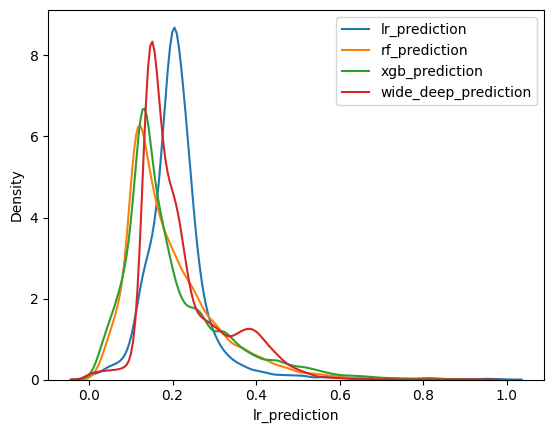

In [27]:
# Look at the distribution of true negatives
axes = plt.subplot()
score_cols = ["lr_prediction", "rf_prediction", "xgb_prediction", "wide_deep_prediction"]
for col in score_cols:
    sns.kdeplot(data=preprocessed_test[preprocessed_test["Label"] == 0], x=col, common_norm=False, ax=axes, label=col,)
plt.legend()

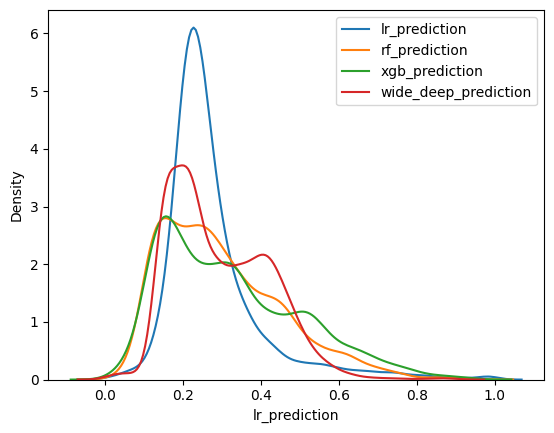

In [28]:
# Look at the distribution of true positives
axes = plt.subplot()
score_cols = ["lr_prediction", "rf_prediction", "xgb_prediction", "wide_deep_prediction"]
for col in score_cols:
    sns.kdeplot(data=preprocessed_test[preprocessed_test["Label"] == 1], x=col, common_norm=False, ax=axes, label=col,)
plt.legend()

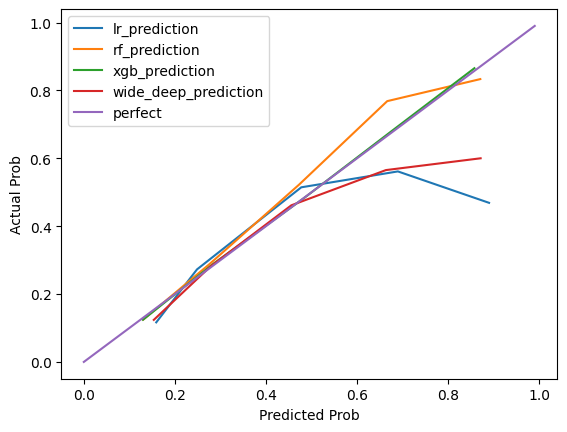

In [29]:
# Look at Calibration curves
from sklearn.calibration import calibration_curve
axes = plt.subplot()
score_cols = ["lr_prediction", "rf_prediction", "xgb_prediction", "wide_deep_prediction"]
for col in score_cols:
    prob_true, prob_pred = calibration_curve(preprocessed_test["Label"], preprocessed_test[col])
    plt.plot(prob_pred, prob_true, label=col)
plt.plot(np.arange(0, 1.0, 0.01), np.arange(0, 1.0, 0.01), label="perfect")
plt.xlabel("Predicted Prob")
plt.ylabel("Actual Prob")
plt.legend()

Overall, we can see that the XGBoost model performs best. This is consistent with the consensus in amonst machine learning practioners that XGBoost is near unbeatable on tabular data. However, it is not a fair comparison because:

1. The data in this notebook is heavily downsampled compared to the actual Criteo data. With more data, we would expect neural networks to perform better than in this example. We would hope to have hundred of thousands / millions of data points for neural networks to truly shine.
2. Hyperparameters have barely been optimised for any model, just using some sensible defaults. Tuning of parameters and adding regularisation could potentially help.
3. We are using a very small set of features, and limiting the number of categories. This is likely hindering the ability for the Wide and Deep model to memorise. Neural network training also has many more hyperparameters that can be tuned (eg. batch size, learning rate schedules, early stopping etc).
4. The Wide and Deep model has a bi-modal distribution, suggesting that it is indeed struggling to learn from the limited rows/features.